In [1]:
%matplotlib inline
from ipywidgets import interact, fixed
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from skimage import io
import seaborn as sns
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_recall_curve
import re
import os
import math

#TODO: plotly
STATS_DIR = '../stats/'

CURRENT_MODEL = ''

In [2]:
model_list = os.listdir(STATS_DIR)

In [3]:
def get_class_hist_image(y_true, y_pred, ax, data_class):
    not_same = y_pred[y_true == 1]
    same = y_pred[y_true == 0]
    
    sns.distplot(same, label='same', ax=ax)
    sns.distplot(not_same, label='not same', ax=ax)
    ax.legend()
    ax.set_title("{} Same or not same distance distribution".format(data_class),  fontsize=14)
    ax.set_xlabel("distance", fontsize=12)
    ax.set_ylabel("frequency", fontsize=12);
    

def get_roc_curve_image(y_true, y_pred, ax, data_class):
    fpr, tpr, thr = roc_curve(y_true, y_pred)

    ax.plot(fpr, tpr)
    ax.set_title("{} ROC curve".format(data_class))
    ax.set_ylabel("True Positive Rate")
    ax.set_xlabel("False Positive Rate");

    
def plot_precision_recall_vs_threshold(y_true, y_pred, ax, data_class):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_pred)
    ax.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    ax.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    ax.set_title("{} precision_recall_vs_threshold".format(data_class))
    ax.set_xlabel("Threshold", fontsize=16)
    ax.legend(loc="upper left", fontsize=16)
    ax.set_ylim([0, 1])
    
def show_pair(df, x, title):
    fig, ax =plt.subplots(1, 2)
    x1_name = "-".join(df.loc[x, "X1"].split("/")[-3:])
    x2_name = "-".join(df.loc[x, "X2"].split("/")[-3:])
    x1 = plt.imread(df.loc[x, "X1"])
    x2 = plt.imread(df.loc[x, "X2"])
    ax[0].imshow(x1)
    ax[0].set_xlabel(x1_name)
    ax[0].set_title("X1")
    ax[1].imshow(x2)
    ax[1].set_xlabel(x2_name)
    ax[1].set_title("X2")
    plt.suptitle('{}. (SAME FRAME, but DIFFERENT ID)\n\n'.format(title), fontsize=10)

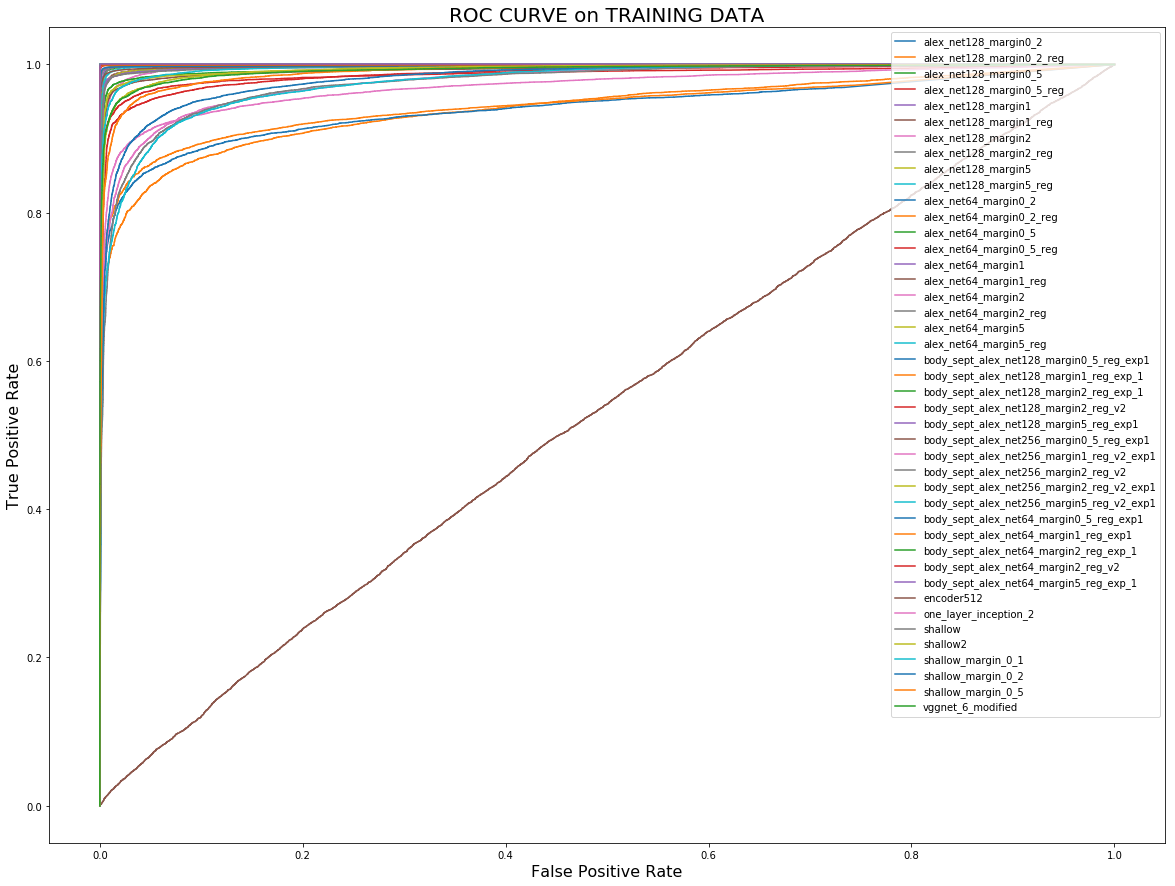

In [4]:
rocs = dict()
plt.figure(figsize=(20,15))
for mod in sorted(os.listdir(STATS_DIR)):
    model_stats_dir = os.path.join(STATS_DIR, mod)
    train_fn = os.path.join(model_stats_dir, mod + "-train_results.csv")
    #test_fn = os.path.join(model_stats_dir, model + "-test_results.csv")
    train_df = pd.read_csv(train_fn)
    rocs[mod] = roc_curve(train_df.y_true, train_df.y_pred)
    plt.plot(rocs[mod][0], rocs[mod][1], label=mod)
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC CURVE on TRAINING DATA", fontsize=20)
plt.legend(loc=1)
plt.savefig("../imgs/roc_curve_training_data.png")

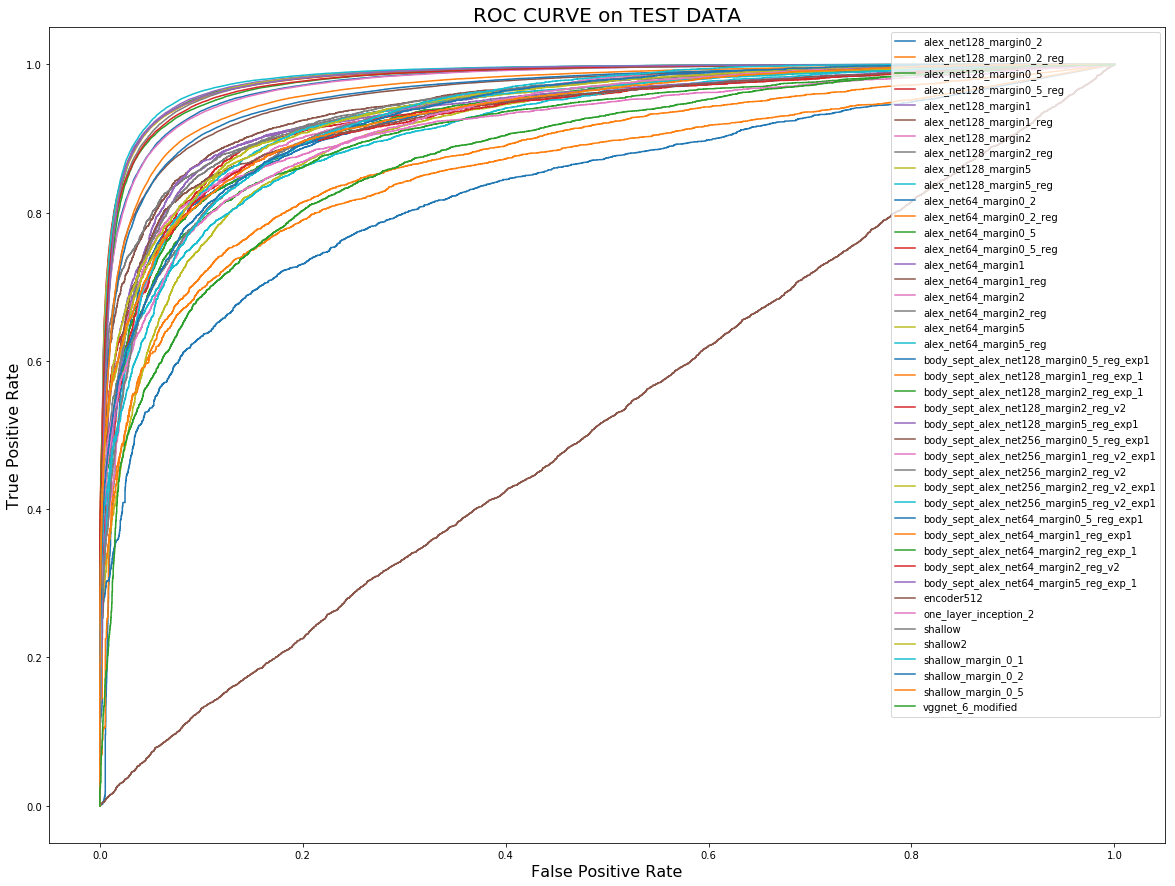

In [5]:
rocs = dict()
plt.figure(figsize=(20,15))
for mod in sorted(os.listdir(STATS_DIR)):
    model_stats_dir = os.path.join(STATS_DIR, mod)
    #train_fn = os.path.join(model_stats_dir, mod + "-train_results.csv")
    test_fn = os.path.join(model_stats_dir, mod + "-test_results.csv")
    test_df = pd.read_csv(test_fn)
    rocs[mod] = roc_curve(test_df.y_true, test_df.y_pred)
    plt.plot(rocs[mod][0], rocs[mod][1], label=mod)
    
plt.xlabel("False Positive Rate", fontsize=16)
plt.ylabel("True Positive Rate", fontsize=16)
plt.title("ROC CURVE on TEST DATA", fontsize=20)
plt.legend(loc=1)
plt.savefig("../imgs/roc_curve_test_data.png")


In [6]:
def f(model, th):
    model_stats_dir = os.path.join(STATS_DIR, model)
    train_fn = os.path.join(model_stats_dir, model + "-train_results.csv")
    test_fn = os.path.join(model_stats_dir, model + "-test_results.csv")
    train_df = pd.read_csv(train_fn)
    test_df = pd.read_csv(test_fn)
    
    fig, ax = plt.subplots(2, 3, figsize=(30,15))

    get_class_hist_image(train_df.y_true, train_df.y_pred, ax[0, 0], "Train")
    get_roc_curve_image(train_df.y_true, train_df.y_pred, ax[0, 1], "Train")
    plot_precision_recall_vs_threshold(train_df.y_true, train_df.y_pred, ax[0, 2], "Train")
    
    get_class_hist_image(test_df.y_true, test_df.y_pred, ax[1, 0], "Test")
    get_roc_curve_image(test_df.y_true, test_df.y_pred, ax[1,1], "Test")
    plot_precision_recall_vs_threshold(test_df.y_true, test_df.y_pred, ax[1,2], "Test")
    
    train_auc = roc_auc_score(train_df.y_true, train_df.y_pred)
    test_auc = roc_auc_score(test_df.y_true, test_df.y_pred)
    
    
    train_acc = accuracy_score(train_df.y_true, (train_df.y_pred > th).astype(np.int64))
    test_acc = accuracy_score(test_df.y_true, (test_df.y_pred > th).astype(np.int64))

    print("Train ACC : ", train_acc)
    print("Test ACC : ", test_acc)
    print("\n\nTrain AUC ROC : ", train_auc)
    print("Test AUC ROC : ", test_auc)

    
interact(f, model=sorted(os.listdir(STATS_DIR)), th=(0, 70, 0.1));

interactive(children=(Dropdown(description='model', options=('alex_net128_margin0_2', 'alex_net128_margin0_2_r…

In [7]:
#def f(model, th):
MODELS_DIRS = sorted(os.listdir(STATS_DIR))
roc_scores = dict()
roc_scores["model"] = list()
roc_scores["train_auc_roc"] = list()
roc_scores["test_auc_roc"] = list()

for model in MODELS_DIRS:
    model_stats_dir = os.path.join(STATS_DIR, model)
    train_fn = os.path.join(model_stats_dir, model + "-train_results.csv")
    test_fn = os.path.join(model_stats_dir, model + "-test_results.csv")
    train_df = pd.read_csv(train_fn)
    test_df = pd.read_csv(test_fn)
    
    train_auc = roc_auc_score(train_df.y_true, train_df.y_pred)
    test_auc = roc_auc_score(test_df.y_true, test_df.y_pred)
    roc_scores["model"].append(model)
    roc_scores["train_auc_roc"].append(train_auc)
    roc_scores["test_auc_roc"].append(test_auc)


In [8]:
AUC_TABLE = pd.DataFrame(roc_scores)

In [9]:
#AUC_TABLE

In [10]:
body_idx = AUC_TABLE.model.str.contains("exp")

In [11]:
BODY_AUC_TABLE = AUC_TABLE[body_idx]

In [12]:
alex_net64_idx = BODY_AUC_TABLE.model.str.contains("body_sept_alex_net64")
alex_net128_idx = BODY_AUC_TABLE.model.str.contains("body_sept_alex_net128")
alex_net256_idx = BODY_AUC_TABLE.model.str.contains("body_sept_alex_net256")

In [13]:
BODY_AUC_TABLE.count()

model            12
train_auc_roc    12
test_auc_roc     12
dtype: int64

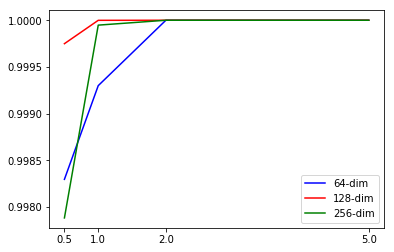

In [14]:
plt.plot([0.5, 1, 2, 5], BODY_AUC_TABLE[alex_net64_idx]["train_auc_roc"].values, "b-", label="64-dim")
plt.plot([0.5, 1, 2, 5], BODY_AUC_TABLE[alex_net128_idx]["train_auc_roc"].values, "r-", label="128-dim")
plt.plot([0.5, 1, 2, 5], BODY_AUC_TABLE[alex_net256_idx]["train_auc_roc"].values, "g-", label="256-dim")
plt.xticks([0.5, 1, 2, 5])
plt.legend();

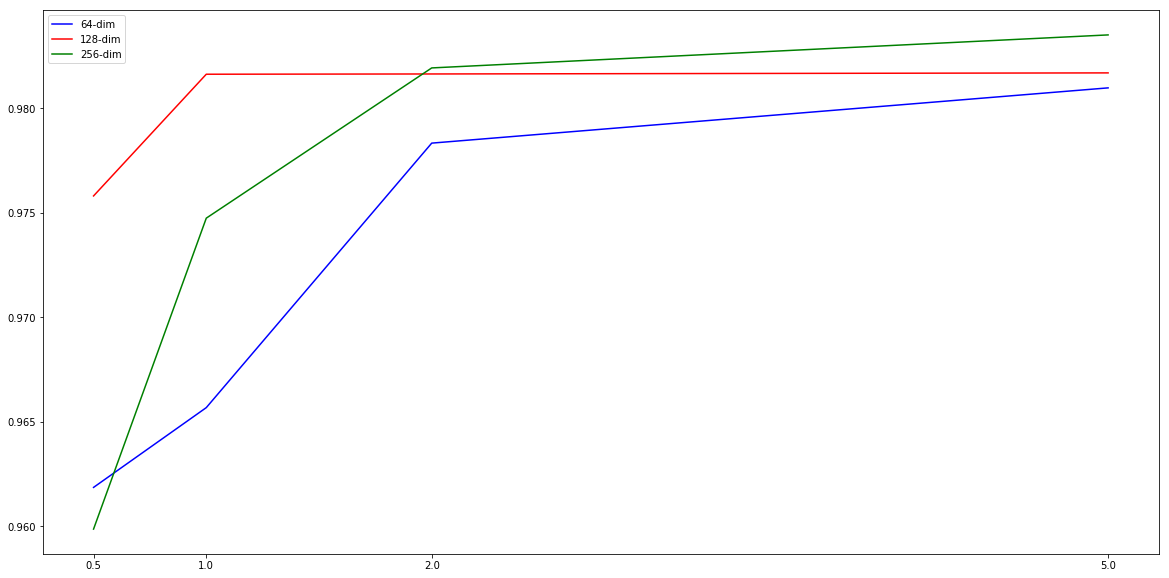

In [15]:
plt.figure(figsize=(20,10))
plt.plot([0.5, 1, 2, 5], BODY_AUC_TABLE[alex_net64_idx]["test_auc_roc"].values, "b-", label="64-dim")
plt.plot([0.5, 1, 2, 5], BODY_AUC_TABLE[alex_net128_idx]["test_auc_roc"].values, "r-", label="128-dim")
plt.plot([0.5, 1, 2, 5], BODY_AUC_TABLE[alex_net256_idx]["test_auc_roc"].values, "g-", label="256-dim")
plt.xticks([0.5, 1, 2, 5], )
plt.legend();

In [16]:
AUC_TABLE = AUC_TABLE.sort_values("test_auc_roc", ascending=False)

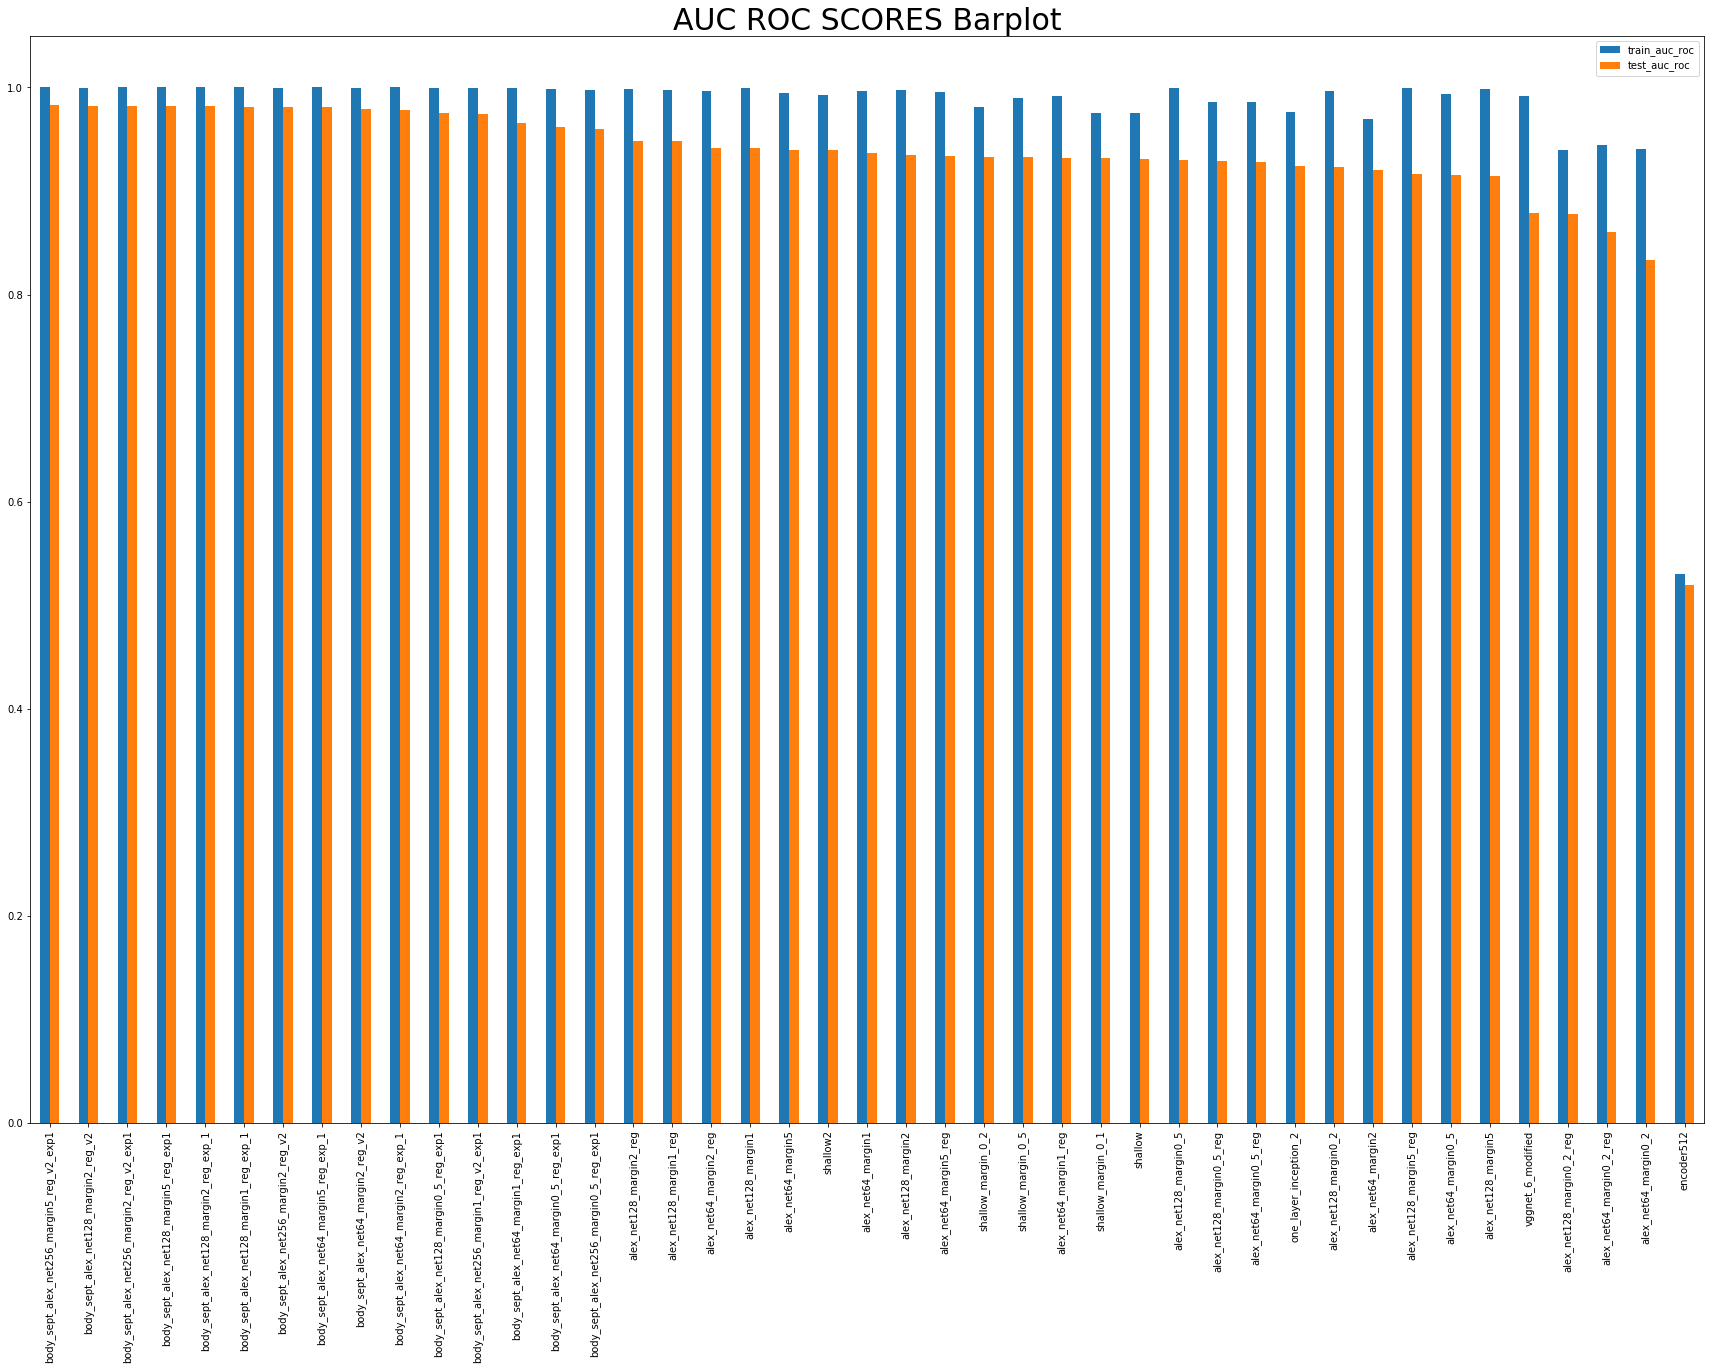

In [17]:
ax = AUC_TABLE.plot(x="model", kind="bar", figsize=(30,20), title="AUC ROC SCORES Barplot", fontsize=10)
ax.set_title("AUC ROC SCORES Barplot", fontsize=30)
ax.set_xlabel("")
plt.savefig("../imgs/auc_roc_barplot.png")

In [18]:
def show_cases(model, th):
    model_stats_dir = os.path.join(STATS_DIR, model )
    train_fn = os.path.join(model_stats_dir, model + "-train_results.csv")
    test_fn = os.path.join(model_stats_dir, model + "-test_results.csv")
    train_df = pd.read_csv(train_fn).sort_values("y_pred", ascending=False)
    test_df = pd.read_csv(test_fn).sort_values("y_pred", ascending=False)

    false_negatives = test_df[(test_df.y_true == 1) & (test_df.y_pred < th)].reset_index()
    fn_size = len(false_negatives) - 1
    false_positives = test_df[(test_df.y_true == 0) & (test_df.y_pred > th)].reset_index()
    fp_size = len(false_positives) - 1
    true_positives = test_df[(test_df.y_true == 1) & (test_df.y_pred > th)].reset_index()
    tp_size = len(true_positives) - 1
    true_negatives = test_df[(test_df.y_true == 0) & (test_df.y_pred < th)].reset_index()
    tn_size = len(true_negatives) - 1
    
    interact(show_pair, df=fixed(false_negatives), x=(0,fn_size,1), title=fixed("False Negative"))
    interact(show_pair, df=fixed(false_positives), x=(0,fp_size,1), title=fixed("False Positive"))
    interact(show_pair, df=fixed(true_negatives), x=(0,tn_size,1), title=fixed("True Negative"))
#     show_pair(false_positives, fp, "False Positive")
#     show_pair(true_negatives, tn, "True Negative")
    plt.show()
    
    
    
interact(show_cases, model=os.listdir(STATS_DIR), th=(0, 20, 0.2));

interactive(children=(Dropdown(description='model', options=('body_sept_alex_net128_margin1_reg_exp_1', 'shall…